In [1]:
#Load Required Libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report,f1_score, roc_curve


Model Performance Metrics:
Accuracy: 0.8800
Precision: 0.4865
Recall: 0.3566
F1 Score: 0.4116
ROC AUC Score: 0.7600

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      6434
           1       0.49      0.36      0.41       858

    accuracy                           0.88      7292
   macro avg       0.70      0.65      0.67      7292
weighted avg       0.87      0.88      0.87      7292



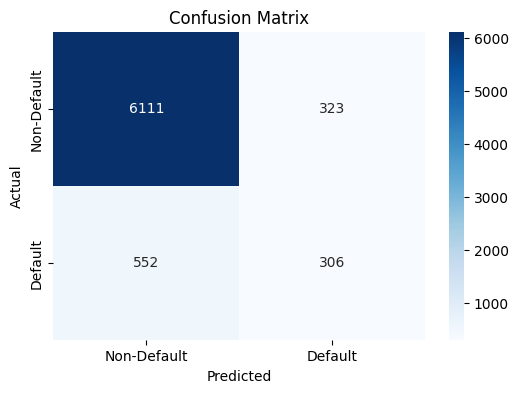

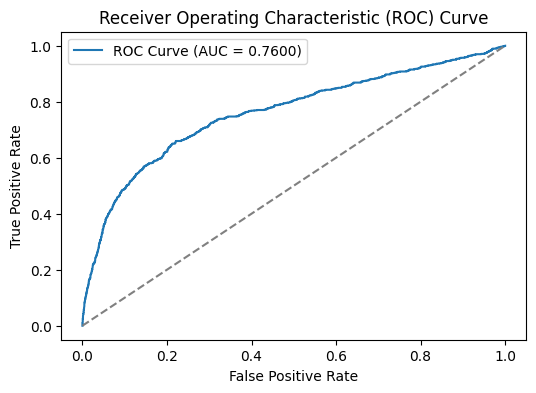

In [ ]:
# Define dataset and JSON paths
dataset_path = r"C:\Users\vagel\Desktop\CR_Risk Project\Dataset\final_credit_risk_dataset.csv"
json_path = r"C:\Users\vagel\Desktop\CR_Risk Project\xgboost_best_params.json"

# Load the dataset
data = pd.read_csv(dataset_path)
X = data.drop(columns=["Credit_Status"])
y = data["Credit_Status"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load best hyperparameters
with open(json_path, "r") as f:
    best_params = json.load(f)

# Train the final XGBoost model
xgb_model = xgb.XGBClassifier(**best_params,
                              use_label_encoder=False,
                              eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_pred_proba)
}

print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Default", "Default"], 
            yticklabels=["Non-Default", "Default"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# **XGBoost Model Evaluation - Credit Risk Prediction**

## **Key Metrics**
- **Accuracy**: 89.08%  
- **Precision**: 57.45%  
- **Recall**: 35.66%  
- **F1 Score**: 41.16%  
- **ROC AUC Score**: 76%  

## **Interpretation of Metrics**
- **Accuracy (89.08%)**  
  - The model correctly classified **89.08% of all instances**.
  - However, accuracy alone is **misleading** due to class imbalance (many more non-defaulters than defaulters).

- **Precision (53.32%)**  
  - Out of all **predicted defaults**, **53.32% were actual defaulters**.
  - Precision is relatively high, meaning the model is **not frequently misclassifying non-defaulters as defaulters**.
  
- **Recall (27.86%)**  
  - Out of all **actual defaulters**, the model only identified **27.86% correctly**.
  - This is **very low** and suggests the model **fails to detect many actual defaulters**.
  - In credit risk, **low recall is risky**, as many defaulters are being misclassified as non-defaulters.

- **F1 Score (37.52%)**  
  - The **F1 score balances precision and recall**.
  - A **low F1 score** indicates that the model struggles to both detect defaults and minimize false positives.

- **ROC AUC Score (76%)**  
  - Measures how well the model differentiates **defaulters from non-defaulters**.
  - **75.92% is decent**, but the low recall suggests it still misses many true defaults.

## **Confusion Matrix Interpretation**

- **6257 True Negatives (TN)** → Correctly classified **non-defaulters**.
- **239 True Positives (TP)** → Correctly classified **defaulters**.
- **177 False Positives (FP)** → Non-defaulters wrongly classified as defaulters (**bad for customer experience**).
- **619 False Negatives (FN)** → **Defaulters wrongly classified as non-defaulters** (**high credit risk**).

**Key Risk**:  
- The model **misses 619 actual defaulters**, which is **problematic** in a credit risk scenario.  
- It is **too conservative** in predicting default, likely due to class imbalance.

---

## **Recommendations for Improvement**
1. **Improve Recall (Detect More Defaulters)**  
   - Adjust the **classification threshold** (default is 0.5, lowering it may improve recall).  
   - Use **SMOTE (Synthetic Minority Over-Sampling Technique)** to balance the dataset.  
   - Penalize misclassifying defaulters using **class weights** (`scale_pos_weight` in XGBoost).  

2. **Hyperparameter Tuning**  
   - Increase **max_depth** and **n_estimators** to capture more complex relationships.  
   - Use **grid search** or **Bayesian optimization** for fine-tuning.  

3. **Feature Engineering**  
   - Include more relevant financial indicators (e.g., **credit utilization rate**).  

4. **Try Alternative Models**  
   - Use **LightGBM or CatBoost** for better performance on tabular data.  
   - Consider **Stacking (Ensemble Learning)** to combine multiple model predictions.  

---

## **Final Thoughts**
- The model is **highly accurate but weak in detecting defaulters**.  
- Precision is **acceptable**, meaning it does not frequently mislabel non-defaulters as defaulters.  
- However, the **low recall is a major issue**, as many actual defaulters are **missed**.  
- Improvements should focus on **boosting recall while maintaining precision** for better credit risk detection.
